<a href="https://colab.research.google.com/github/tmnestor/.dotfiles/blob/main/Roberta_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)

In [1]:
# TO link colab with google drive
# #@title colab setup steps (takes about 12 minutes)
# from google.colab import drive
# drive.mount('/content/drive')
# ![[ -d "/content/drive/MyDrive/Colab Notebooks/Roberta_Classification/" ]] && rm -rf "/content/drive/MyDrive/Colab Notebooks/Roberta_Classification/"
# %mkdir '/content/drive/MyDrive/Colab Notebooks/Roberta_Classification/'
# %cd '/content/drive/MyDrive/Colab Notebooks/Roberta_Classification/'
# !git clone https://github.com/tmnestor/Roberta_Classification.git .
# !pip install transformers

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Roberta_Classification
Cloning into '.'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 4), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (12/12), 1.83 MiB | 5.65 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.8 MB/s eta 0:00:00


In [3]:
import torch, torchtext
from torchtext.functional import to_tensor
roberta_base = torchtext.models.ROBERTA_BASE_ENCODER
model = roberta_base.get_model()
transform = roberta_base.transform()
input_batch = ["Hello world", "How are you today my friend", "Here is yet another pointless sentence"]
model_input = to_tensor(transform(input_batch), padding_value=1)
output = model(model_input)
output.shape

Downloading: "https://download.pytorch.org/models/text/roberta.base.encoder.pt" to /root/.cache/torch/hub/checkpoints/roberta.base.encoder.pt


  0%|          | 0.00/237M [00:00<?, ?B/s]

100%|██████████| 1.04M/1.04M [00:01<00:00, 982kB/s]
100%|██████████| 456k/456k [00:00<00:00, 31.1MB/s]
Downloading: "https://download.pytorch.org/models/text/roberta.vocab.pt" to /root/.cache/torch/hub/checkpoints/roberta.vocab.pt


  0%|          | 0.00/726k [00:00<?, ?B/s]

torch.Size([3, 8, 768])

In [5]:
import pandas as pd
datapath = 'data/bbc-text.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<AxesSubplot:xlabel='category'>

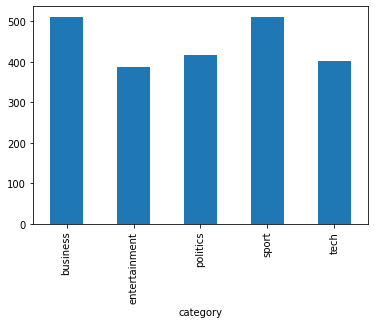

In [6]:
df.groupby(['category']).size().plot.bar()

In [7]:
# from transformers import BertTokenizer
from transformers import RobertaTokenizer

# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

example_text = 'I will watch Memento tonight'
roberta_input = tokenizer(example_text,padding='max_length', 
  max_length = 10, truncation=True, return_tensors="pt")

In [8]:
roberta_input

{'input_ids': tensor([[   0,  100,   40, 1183,  256, 6285,  139, 3422,    2,    1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}

In [9]:
print(roberta_input['input_ids'])
print(roberta_input['attention_mask'])

tensor([[   0,  100,   40, 1183,  256, 6285,  139, 3422,    2,    1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])


In [10]:
example_text = tokenizer.decode(roberta_input.input_ids[0])

print(example_text)

<s>I will watch Memento tonight</s><pad>


In [11]:
import torch
import numpy as np
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [12]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [13]:
from torch import nn
from transformers import RobertaModel

class RobertaClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(RobertaClassifier, self).__init__()

        self.bert = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [14]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 2
model = RobertaClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [03:29<00:00,  4.25it/s]


Epochs: 1 | Train Loss:  0.576                 | Train Accuracy:  0.565                 | Val Loss:  0.169                 | Val Accuracy:  0.977


100%|██████████| 890/890 [03:29<00:00,  4.25it/s]


Epochs: 2 | Train Loss:  0.104                 | Train Accuracy:  0.972                 | Val Loss:  0.080                 | Val Accuracy:  0.968


In [15]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.973
